In [18]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
#define Value class

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [24]:
#visualization
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [25]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

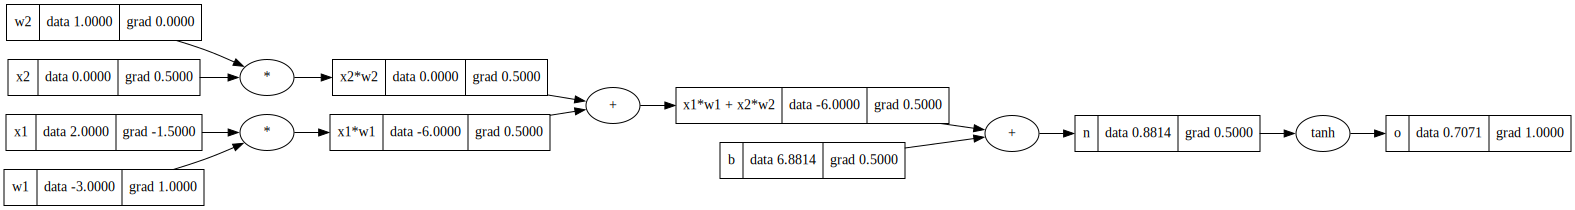

In [26]:
draw_dot(o)

In [27]:
o.backward()

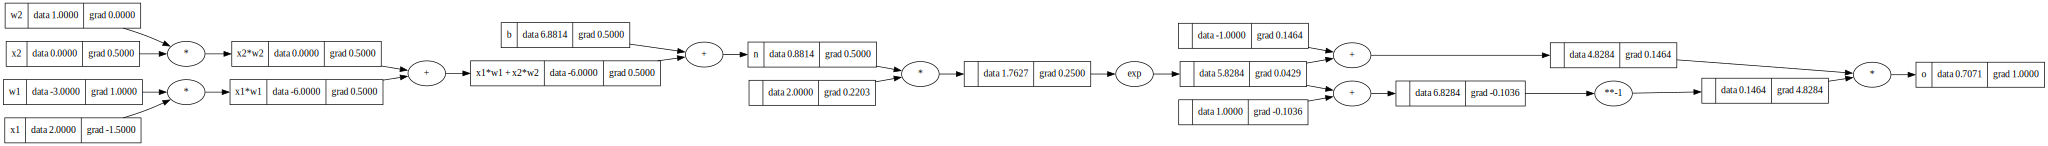

In [28]:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [29]:
import torch

In [30]:
#create pyTorch model and compare it with micrograd result
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [31]:
#create neurons and a neural network
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [32]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.7597189972867735)

In [38]:
n.parameters()

[Value(data=0.03475062281562158),
 Value(data=0.5284738883642852),
 Value(data=0.3251702682206632),
 Value(data=0.2662892413108946),
 Value(data=-0.21589931717231403),
 Value(data=0.9221975882563507),
 Value(data=0.9618055572934769),
 Value(data=0.8978972544275259),
 Value(data=0.47085738239773645),
 Value(data=-0.5344177888551618),
 Value(data=-0.1250084961015394),
 Value(data=0.900932579512143),
 Value(data=-0.9711814685978521),
 Value(data=-0.4515315102218034),
 Value(data=-0.4349990271984028),
 Value(data=0.39674330908469524),
 Value(data=-0.9414544896833048),
 Value(data=0.8223712044892795),
 Value(data=-0.19145398067890285),
 Value(data=-0.22116112912926078),
 Value(data=0.9588446798607289),
 Value(data=-0.798429274291901),
 Value(data=0.3512167933824186),
 Value(data=0.2504367665451823),
 Value(data=0.3960108715682167),
 Value(data=-0.3507509606949719),
 Value(data=-0.08905904735123782),
 Value(data=0.9568055737286913),
 Value(data=-0.7684623966178319),
 Value(data=0.39734086605

In [39]:
len(n.parameters())

41

In [33]:
#example, how to tune the weights to achieve the desired targets
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred= [n(x) for x in xs]
ypred

[Value(data=-0.7597189972867735),
 Value(data=0.5045799918644033),
 Value(data=-0.7697335822692252),
 Value(data=-0.5202834457040157)]

In [34]:
#define loss, describes how the neural net is performing
#implement mean square loss function
#loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
#[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.724656279746894)

In [35]:
#calculate gradients
loss.backward()

In [36]:
#print calculated grad of weight
n.layers[0].neurons[0].w[0].grad

2.305905640903881

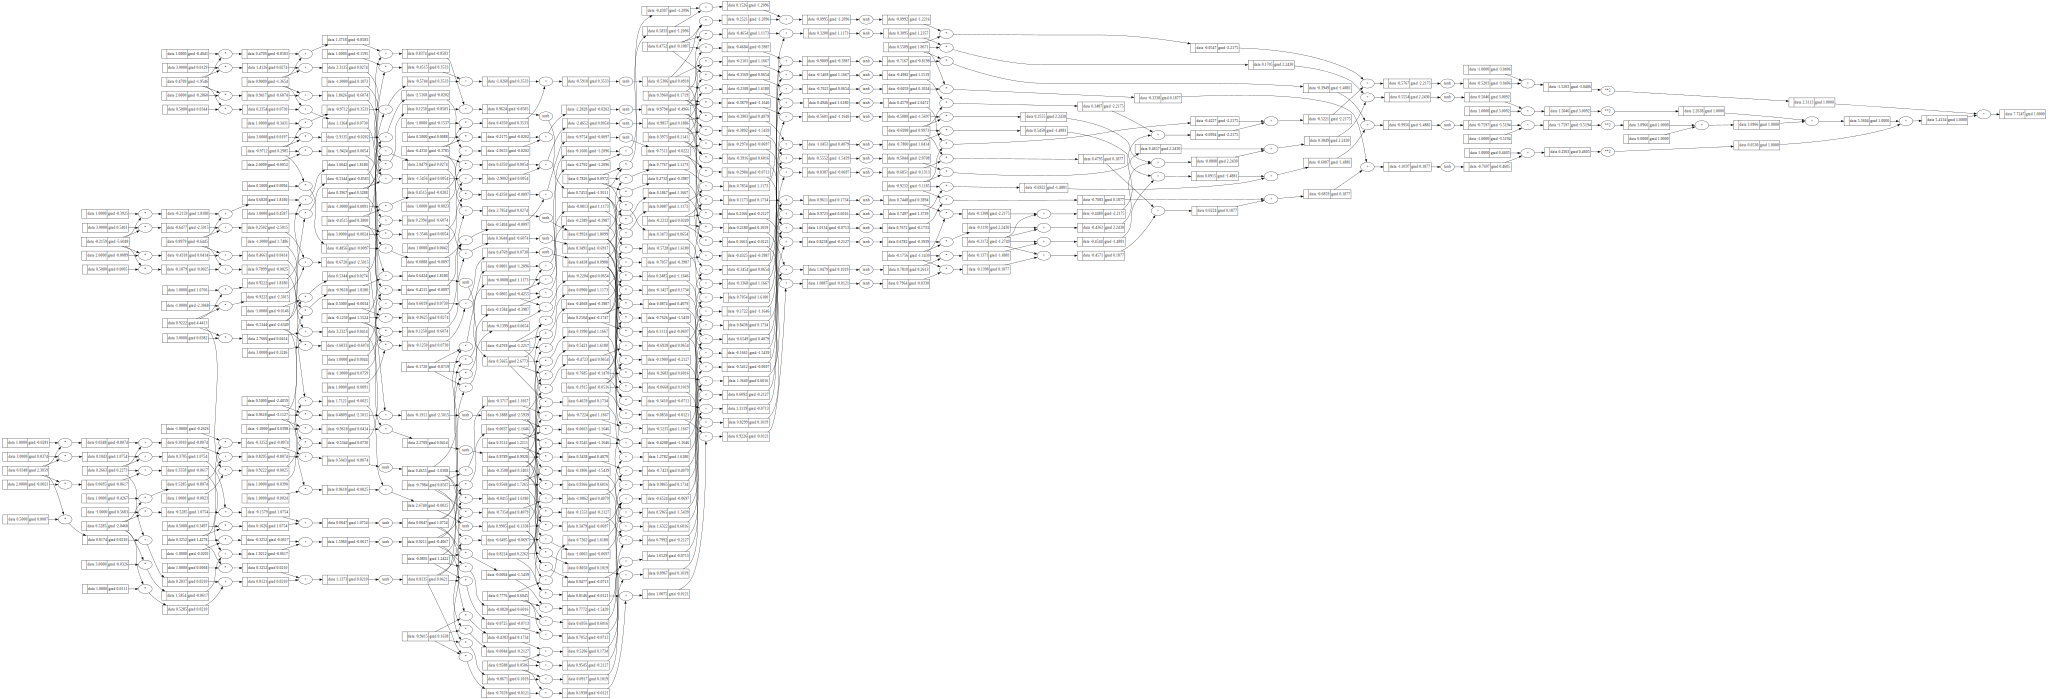

In [37]:
draw_dot(loss)

In [40]:
#before training neural net
ypred= [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=7.724656279746894)

In [43]:
#after each training step
ypred= [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.9477325517525648)

In [41]:
#calculate gradients
loss.backward()

In [42]:
#tiny update in gradient descent scheme
for p in n.parameters():
    p.data += -0.1 * p.grad

In [44]:
#setting weights and biases that makes the network predict the desire target
n.parameters()

[Value(data=-0.4264305053651547),
 Value(data=0.9378335286138852),
 Value(data=0.03961427819242874),
 Value(data=0.22083038682509545),
 Value(data=0.9050557101195065),
 Value(data=0.03394519879325819),
 Value(data=1.58434983039919),
 Value(data=1.0268024286830915),
 Value(data=0.8617753152089742),
 Value(data=-0.007429694022428435),
 Value(data=-0.4354794919249303),
 Value(data=1.1740148562712545),
 Value(data=-1.0308819890021745),
 Value(data=-0.5275361933037973),
 Value(data=-0.35930334745999903),
 Value(data=0.3309851453527549),
 Value(data=-0.9742165014397798),
 Value(data=0.7771245492171298),
 Value(data=-0.18113154575563134),
 Value(data=-0.22614130660624848),
 Value(data=0.9487296699925205),
 Value(data=-0.9697712346355026),
 Value(data=0.10899806260217582),
 Value(data=0.2853787694980378),
 Value(data=0.3616397436725013),
 Value(data=-0.41881273867900803),
 Value(data=-0.3375034336932542),
 Value(data=0.6115067419493043),
 Value(data=-0.7389058799589986),
 Value(data=0.37452495

In [45]:
#automate the finale step
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    #we have to reset to zero
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 2.9477325517525648
1 2.104283375386984
2 1.5166688208532941
3 0.6140714984939687
4 0.2321488273536854
5 0.057563053476893986
6 0.04577316780436788
7 0.038251492397138626
8 0.032893070009225506
9 0.028846707969920456
10 0.025673313108848246
11 0.02311529345538072
12 0.021009058019412732
13 0.01924487837112331
14 0.017746099992991232
15 0.016457436976525908
16 0.015337965183495556
17 0.01435672542448704
18 0.01348985821063741
19 0.0127186774049615


In [46]:
#prediction after optimization
ypred

[Value(data=0.95384878491551),
 Value(data=-0.9808210027941598),
 Value(data=-0.9321338968688178),
 Value(data=0.9250660233061614)]